In [14]:
import torch
import torchnmf
import matplotlib.pyplot as plt
import tqdm 
import numpy as np
import os
import skimage.io as iio
from tqdm import tqdm

In [15]:
# load in some data to be factorized
path = '/home/nrt2124/engram/cuttlefish/CUTTLEFISH_BEHAVIOR/cuttle_data_storage/2024_Interesting_skin_compiled_dataset/Nice skin manual crops/Lightroom Export_full res/'
files = np.sort(os.listdir(path))
images = iio.ImageCollection(path + '/*.tif')
cuts = [1080, 720]
cut_0 = cuts[0]
cut_1 = cuts[1]

shapes = np.empty((3, len(images)))
for i, image in enumerate(tqdm(images)):
   for j in range(3):
      shapes[j,i] = image.shape[j]

mask_0 = shapes[0,:] > cut_0
mask_1 = shapes[1,:] > cut_1

index_mask0 = np.where(mask_0 == True)[0]
index_mask1 = np.where(mask_1 == True)[0]

full_mask = np.intersect1d(index_mask0, index_mask1)

#first filter out unusually small images
print(len(images))
images_cut = [images[i] for i in full_mask]
print(len(images_cut))
print(len(full_mask))

100%|██████████| 430/430 [00:05<00:00, 75.48it/s]


430
382
382


In [16]:
def crop_image_to_size(image, output_size):
    height, width, c = image.shape


    # Desired output size
    new_height, new_width = output_size


    # Calculate coordinates to crop at the center
    start_x = (width // 2) - (new_width // 2)
    start_y = (height // 2) - (new_height // 2)

    # Crop the image
    cropped_img = image[start_y:start_y+new_height, start_x:start_x+new_width]
    return cropped_img



cropped_ims  = []
for image_cut in tqdm(images_cut):
    cropped_ims.append(crop_image_to_size(image_cut, (cut_0, cut_1)))

100%|██████████| 382/382 [00:00<00:00, 286418.33it/s]


In [18]:
#implement nmf on some data:

#Now for NMF
dataset = np.asarray(cropped_ims)

#grayscale data
gray_data = 0.2989*dataset[:,:,:,0] + 0.5870*dataset[:,:,:,1]+0.1140*dataset[:,:,:,2]

gray_data_flattened = gray_data.reshape(gray_data.shape[0], -1)
print(gray_data_flattened.shape) #382 flattend images :)


(382, 777600)


In [78]:
# now for gpu stuff!
from torchnmf.nmf import NMF
V = torch.tensor(gray_data_flattened)


model = NMF(V.shape, rank=100)
print(model.W.size())
print(model.H.size())




torch.Size([777600, 100])
torch.Size([382, 100])


In [79]:
#move to the gpu
V = V.cuda()
model = model.cuda()

In [80]:
model.fit(V)

200

In [117]:
model.cpu()
W = model.W.detach().numpy()
H = model.H.detach().numpy()

In [118]:
W.shape

(777600, 100)

In [120]:
# reshape to images
features_images = np.empty((H.shape[0], gray_data.shape[1], gray_data.shape[2]))
for i, factor in enumerate(W.T):
    features_images[i] = factor.reshape(gray_data.shape[1], gray_data.shape[2])

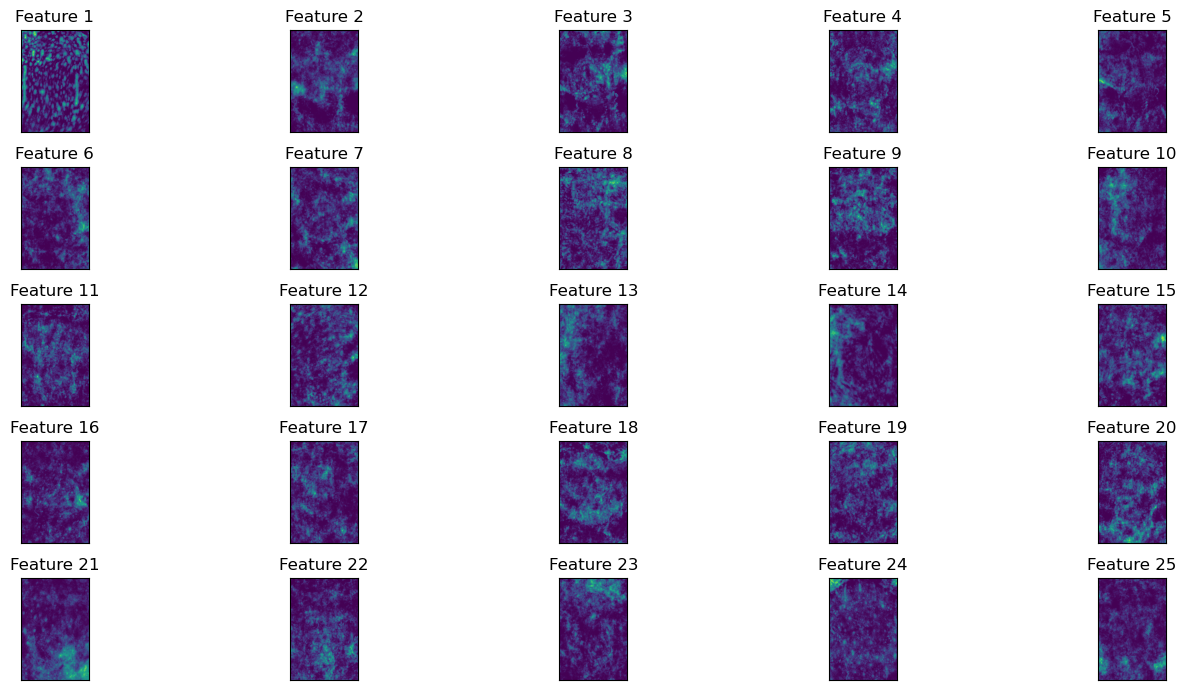

In [122]:
fig, axes = plt.subplots(5, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(features_images[i+25])
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()